## Benchmark 4: oneshot naive model cross validation
Major consideration here is, do we score one time point from the forecast period or all four? Thinking we should probably do both. Scoring one point will give us the best comparison to the current public leaderboard. But the actual model we need to build will be predicting four future timepoints.

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf

import numpy as np
import pandas as pd

print(f'Python: {sys.version}')
print()
print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Numpy 1.23.5
Pandas 1.4.3


In [2]:
# Load cross validation data
model_order = 4
forecast_horizon = 4

input_file = f'{conf.PARSED_DATA_PATH}/order{model_order}_horizon{forecast_horizon}.npy'
parsed_data = np.load(input_file)

print(f'Shape: {parsed_data.shape}')

Shape: (100320, 2, 4, 4)


OK this, numpy array is structured as follows:
+ **First dimension**: data elements
+ **Second dimension**: input, forecast block halves
+ **Third dimension**: rows
+ **Fourth dimension**: columns: *cfips, first_day_of_month, microbusiness_density, active*

Let's start by defining some helper functions so that we can easily loop over multiple samples, calculating training and validation scores for each.

In [3]:
def sample_parsed_data(
    parsed_data,
    training_fraction      
):
    '''Randomly select 30% of the data for validation, keep the rest for training'''

    # Calculate sample sizes
    training_sample_size = int(len(parsed_data) * training_fraction)

    # Generate list of random indices for training sample
    random_training_indices = np.random.choice(parsed_data.shape[0], training_sample_size, replace=False)

    # Use random indices to extract training sample from parsed data
    training_sample = parsed_data[random_training_indices]

    # Loop on parsed_data indices, if index was not in random validation sample
    # add that data to the validation sample
    random_validation_indices = []
    validation_sample = []

    for i in range(len(parsed_data)):
        if i not in random_training_indices:
            validation_sample.append(parsed_data[i])

    # Convert to numpy array
    validation_sample = np.array(validation_sample)

    return training_sample, validation_sample

In [4]:
def two_point_smape(actual, forecast):

    if actual == 0 and forecast == 0:
        return 0

    smape = abs(forecast - actual) / ((abs(actual) + abs(forecast)) / 2)
    
    return smape

In [5]:
def naive_model_smape_score(sample):
    one_point_smape_values = []
    four_point_smape_values = []

    for block in sample:

        # Get the last microbusiness_density value from the input block
        forecast_value = block[0,-1,2]

        # Score the 'prediction'
        actual_values = block[1,0:,2]

        smape_values = []

        for actual_value in actual_values:
            smape_values.append(two_point_smape(actual_value, forecast_value))

        one_point_smape_values.append(smape_values[0])
        four_point_smape_values.extend(smape_values)

    one_point_smape_score = (100/len(one_point_smape_values)) * sum(one_point_smape_values)
    four_point_smape_score = (100/len(four_point_smape_values)) * sum(four_point_smape_values)

    return one_point_smape_score, four_point_smape_score

In [6]:
smape_scores = {
    'one_point_training': [],
    'one_point_validation': [],
    'four_point_training': [],
    'four_point_validation': []
}

for i in range(100):

    training_sample, validation_sample = sample_parsed_data(
        parsed_data,
        0.7    
    )

    one_point_training_smape, four_point_training_smape = naive_model_smape_score(training_sample)
    one_point_validation_smape, four_point_validation_smape = naive_model_smape_score(validation_sample)

    smape_scores['one_point_training'].append(one_point_training_smape)
    smape_scores['one_point_validation'].append(one_point_validation_smape)
    smape_scores['four_point_training'].append(four_point_training_smape)
    smape_scores['four_point_validation'].append(four_point_validation_smape)

    print(f'Fold {i} SMAPE scores:')
    print(f'\tOne point training: {one_point_training_smape}')
    print(f'\tOne point validation: {one_point_validation_smape}')
    print(f'\tFour point training: {four_point_training_smape}')
    print(f'\tFour point validation: {four_point_validation_smape}')
    print()

Fold 0 SMAPE scores:
	One point training: 1.7851165148344879
	One point validation: 1.7485523989907044
	Four point training: 3.0996716507627555
	Four point validation: 3.0474661321617567

Fold 1 SMAPE scores:
	One point training: 1.7755688748731917
	One point validation: 1.7708302255671042
	Four point training: 3.0890829130027924
	Four point validation: 3.072173186934979

Fold 2 SMAPE scores:
	One point training: 1.778998915160639
	One point validation: 1.7628267982297208
	Four point training: 3.098471923215044
	Four point validation: 3.0502654964396565

Fold 3 SMAPE scores:
	One point training: 1.7799399768373325
	One point validation: 1.7606309876507766
	Four point training: 3.0953251428822623
	Four point validation: 3.057607983882742

Fold 4 SMAPE scores:
	One point training: 1.7626089174928046
	One point validation: 1.8010701261213347
	Four point training: 3.079557651926294
	Four point validation: 3.094398796113327

Fold 5 SMAPE scores:
	One point training: 1.7703065632542119
	One 

In [8]:
for key, val in smape_scores.items():
    print(f'{key}: {val[:5]}...')

one_point_training: [1.7851165148344879, 1.7755688748731917, 1.778998915160639, 1.7799399768373325, 1.7626089174928046]...
one_point_validation: [1.7485523989907044, 1.7708302255671042, 1.7628267982297208, 1.7606309876507766, 1.8010701261213347]...
four_point_training: [3.0996716507627555, 3.0890829130027924, 3.098471923215044, 3.0953251428822623, 3.079557651926294]...
four_point_validation: [3.0474661321617567, 3.072173186934979, 3.0502654964396565, 3.057607983882742, 3.094398796113327]...


In [9]:
smape_scores_df = pd.DataFrame(smape_scores)
smape_scores_df.head()

,one_point_training,one_point_validation,four_point_training,four_point_validation
0,1.785117,1.748552,3.099672,3.047466
1,1.775569,1.770830,3.089083,3.072173
2,1.778999,1.762827,3.098472,3.050265
3,1.779940,1.760631,3.095325,3.057608
4,1.762609,1.801070,3.079558,3.094399


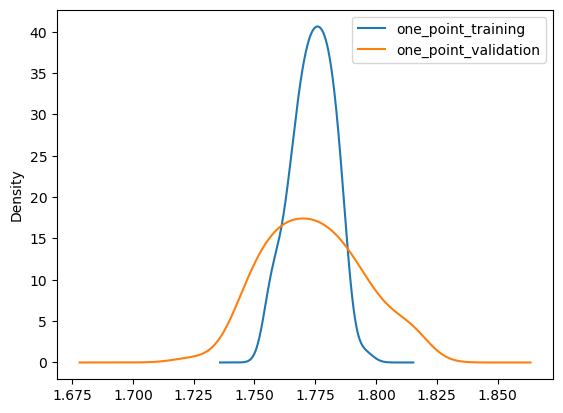

In [17]:
one_point_smape_scores_df = smape_scores_df[['one_point_training', 'one_point_validation']]
ax = one_point_smape_scores_df.plot.kde(xlabel = 'SMAPE')

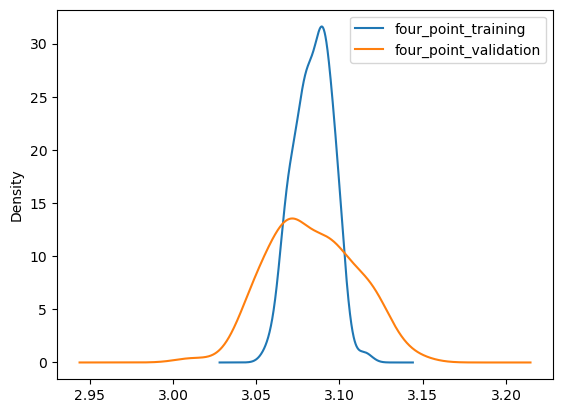

In [18]:
one_point_smape_scores_df = smape_scores_df[['four_point_training', 'four_point_validation']]
ax = one_point_smape_scores_df.plot.kde(xlabel = 'SMAPE')

OK - so cross validation SMAPE scores are quite a bit higher than the public leaderboard score using the same 'model'. I also notice that the four point SMAPE is much larger than the one point SMAPE. Will have to come back and look at this with fresh eyes to see if this is expected behavior or if there is a problem with my calculations.

Anyway that's the first pass at it complete.